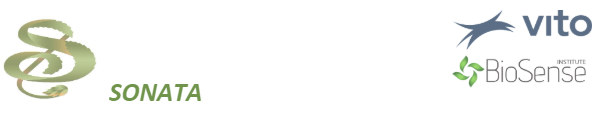
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### pipeline to extract EO and non-EO features (biophysical indicators) for EUNIS habitat reference data

In [1]:
from eo_processing.utils.helper import init_connection
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.utils.mgrs import gridID_2_epsg
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import geojson
import openeo
from openeo.extra.job_management import CsvJobDatabase
import platform
import traceback

#### declaration area
This declaration area is adapted for the training. Adapt for more automated loading of CSV files which have to contain at minimum the columns ['center_lon', 'center_lat', 'grid20id', 'MGRSid10'] for each reference point. In case these columns were not generated before, run the `from eo_processing.utils.geoprocessing import get_point_info` function on the dataframe via apply().

In [2]:
# CSV file for feature extraction
csv_reference_points = os.path.normpath(r'./data/final_reference_points_Serbia_labeled.csv')

# processing parameters
processing_year = 2024
topology = 'EUNIS2021plus'

# set input and output folders
if platform.system() == 'Windows':
    # global tiling grid (ONLY needed for job status visualization - if no graphic dashboard required we have to adapt the code)
    path_global_grid = os.path.normpath(r'\\netapp03.vgt.vito.be\habitat\ancillary\global_terrestrial_UTM20k_grid_v2.gpkg')
else:
    path_global_grid = os.path.normpath(r'/data/habitat/ancillary/global_terrestrial_UTM20k_grid_v2.gpkg')

# backend openEO
backend = 'cdse'

# root output folder
root_base = os.path.normpath(r'C:\Users\BUCHHORM\Downloads') # please adapt
out_root = os.path.join(root_base, f'TD-features_{topology}_{processing_year}')
os.makedirs(out_root, exist_ok=True)

#### load the filtered datasets into a GeoDataFrame

It is crucial that the reference data is in EPSG:4326 - identify the correct columns OR warp coordinates of other EPSG to EPSG:4326. The MGRSid10 is a unique GeoLocation identifier at 10m spatial resolution in the UTM grid - this allows that reference point labels can be assigned always to the correct EO/non-EO extracted features. The MGRSid10 has 13-digits and specify the lower left corner of the 10x10 m pixel in the MGRS notation. The center_lon/lat represents the center coordinate of the corresponding 10x10m pixel in the UTM grid (10m square covered by the MGRSid10).
The grid20id shows in which 20x20km processing tile the corresponding reference point falls - that allows the pre-grouping of the reference points for efficient processing.

In [3]:
# read file as Pandas DataFrame
combined_df = pd.read_csv(csv_reference_points)
# check
missing_columns = [col for col in ['center_lon', 'center_lat', 'grid20id', 'MGRSid10'] if col not in combined_df.columns]
if missing_columns:
    from eo_processing.utils.geoprocessing import get_point_info
    combined_df[['MGRSid10', 'center_lon', 'center_lat', 'grid20id']] = combined_df.progress_apply(lambda row: get_point_info(row['Longitude'], row['Latitude']), axis=1, result_type='expand')
combined_df.set_index('MGRSid10', inplace=True)

In [4]:
# remove non-needed columns when exist
lKeep = ['center_lon', 'center_lat', 'grid20id']
combined_df = combined_df[lKeep]
combined_df.head()

,center_lon,center_lat,grid20id
MGRSid10,,,
34TFN80747252,23.220488,43.083902,34σFN43
34TFN79377339,23.203951,43.092056,34σFN33
34TFN72757230,23.122329,43.083784,34σFN33
34TFN70588066,23.098258,43.159506,34σFN34
34TFN78227326,23.189789,43.091157,34σFN33


#### convert the Pandas DataFrame into a GeoPandas DataFrame with center point geometry

In [5]:
geometry = [Point(xy) for xy in zip(combined_df.center_lon, combined_df.center_lat)]
geo_df = gpd.GeoDataFrame(combined_df, geometry=geometry)
geo_df = geo_df.set_crs('epsg:4326')
print(f'Number of reference points: {len(geo_df)}')

Number of reference points: 106


<Axes: >

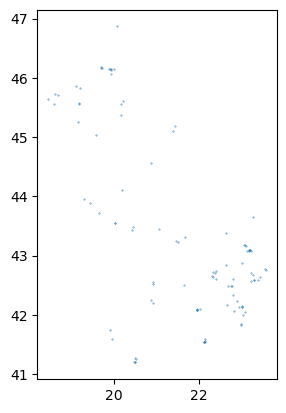

In [6]:
# just visualize for checks
geo_df.geometry.plot(markersize=0.1)

#### split the geodataframe by processing grid

We use the grid20id for the grouping of the reference points. The grid20id hereby represents the tileID in the global 20x20km UTM processing grid. BUT we saw that the maximum tile size can be up to 100x100km (grid100id) if we do no touch more than 256 processing blocks in openEO -> processing block = 128x128 pixel). We assume here therefore that we can aggregate 20x20 km blocks as long we have less then 256 points, but only max the size of a Sentinel-2 UTM tile of 100x100km. ToDo: this spatial aggregation has to be improved later.

In [7]:
def optimized_processing_split(geo_df: gpd.GeoDataFrame) -> list[gpd.GeoDataFrame]:
    # create grid100id from the grid20id representing the 100x100km processing tile
    geo_df['grid100id'] = geo_df.grid20id.str[:5]

    # add a id to group by 20x100km strips (so 5 sub-units per 100x100km tile)
    geo_df['grid20stripid'] = geo_df.grid20id.str[:6]

    # create dataframes which have the count rows by applied grouping by the different ids
    group_counts_100 = geo_df.groupby('grid100id').grid100id.transform('count')
    group_counts_20strip = geo_df.groupby('grid20stripid').grid20stripid.transform('count')

    # add the final grouping id to each row
    geo_df['final_grouping'] = geo_df.apply(
        lambda row:
            row.grid100id if group_counts_100[row.name] < 256
            else (row.grid20stripid if group_counts_20strip[row.name] < 256
                  else row.grid20id),
        axis=1
    )

    # split the jobs
    return [geo_df[geo_df['final_grouping'] == tile_id] for tile_id in geo_df['final_grouping'].unique()]

In [8]:
split_jobs = optimized_processing_split(geo_df)
print(f'Number of jobs: {len(split_jobs)}')

Number of jobs: 21


<Axes: >

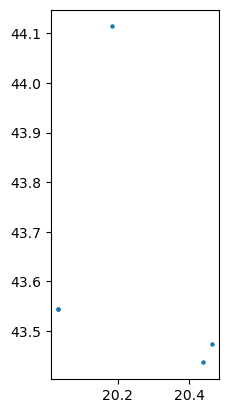

In [9]:
# for visualization we print all the points of one of the processing tiles
split_jobs[10].geometry.plot(markersize=5)

#### create the job dataframe with all info to run the openEO MultiBackendJobManager for the data extraction

For each job which has to run on openEO we need an extra row in a pandas.DataFrame (or geopandas.DataFrame) which is handling all information needed by the JobManager to execute the start_function. The output dataframe should be savable as a .csv file.

Note: the full information of a sub-geodataframe of points/polygons can be saved into a row of a pandas.DataFrame by storing it in a row as string implementing the geojson.FeatureCollection interface. To convert the geopandas.GeoDataFrame into a string, simply use the .to_json() function.

Note: make sure you have a row specific column called "name" in case you want run visualization.

In [10]:
def create_job_dataframe(split_jobs: list[gpd.GeoDataFrame], year: int, file_name_base: str) -> pd.DataFrame:
    """ Create a dataframe from the pre-split GeoDataFrame, containing all the necessary information to run the job.

    :param split_jobs: List of GeoDataFrames, each containing job information such as S2 tile ID and geometries.
    :param year: Year for which to create job entries. The start date will be January 1st of this year, and the end date will be January 1st of the following year.
    :param file_name_base: Base file name to be used, with the S2 tile ID appended to create unique file names for each job.
    :return: DataFrame containing job information, including the S2 tile ID, generated file name, start date, end date, and geometry as a JSON object.
    """

    columns = ['job_name', 'target_epsg', 'file_prefix', 'start_date', 'end_date', 'FeatureCollection']
    dtypes = {'job_name': 'string', 'target_epsg': 'UInt16', 'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string', 'FeatureCollection': object}
    rows = []
    for job in split_jobs:
        # set master parameters
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        gridid = job.final_grouping.iloc[0]  # all jobs have the same id (either grid100id, grid20id, or grid20stripid)
        epsg = gridID_2_epsg(gridid)
        file_prefix = f'{file_name_base}_{gridid}'

        rows.append(
            pd.Series(
                dict(zip(columns, [gridid, epsg, file_prefix, start_date, end_date, job.reset_index()[['MGRSid10', 'geometry']].to_json()])),
            )
        )

    return pd.DataFrame(rows).astype(dtypes)

In [11]:
# set the feature extraction year (here: 2024) and specify the output file name base
job_df = create_job_dataframe(split_jobs, processing_year, f'TD-features_EU-{topology}_year{processing_year}')

In [12]:
# add the number of points to handle in each 20x20km grid cell
def get_point_number(row: pd.Series) -> int:
    """
    :param row: A pandas Series object that contains a geometry field with a GeoJSON string.
    :return: The number of features present in the GeoJSON geometry.
    """
    return len(geojson.loads(row.FeatureCollection)['features'])

job_df['n_points'] = job_df.apply(get_point_number, axis=1)

In [13]:
# for Job status visualization of the training data extraction, we have to add a geometry to each row and convert the Pandas into a GeoPandas DataFrame
# that is the huge difference to inference which is running directly on 20x20km tiles which give the geometry
# Note: since we did a specific spatial grouping we have to apply the same to the tiling grid

def get_combined_processing_grid(path_grid: str, bbox : tuple) -> gpd.GeoDataFrame:
    # since the GeoPackage is huge we use a helper function
    gdf_grid = gpd.read_file(path_grid, bbox=bbox)
    gdf_grid['tile_name'] = gdf_grid.grid20id
    # add the additional ids
    gdf_grid['grid100id'] = gdf_grid.grid20id.str[:5]
    gdf_grid['grid20stripid'] = gdf_grid.grid20id.str[:6]
    # create the polygons for these ids
    gdf_grid100 = gdf_grid.dissolve(by='grid100id').reset_index()
    gdf_grid100['tile_name'] = gdf_grid100.grid100id
    gdf_grid20strip = gdf_grid.dissolve(by='grid20stripid').reset_index()
    gdf_grid20strip['tile_name'] = gdf_grid20strip.grid20stripid

    # merge
    gdf_grid_all = pd.concat([gdf_grid, gdf_grid100, gdf_grid20strip])

    return gdf_grid_all

# get combined processing grid
gdf_grid = get_combined_processing_grid(path_global_grid, tuple(geo_df.total_bounds))

# merge in the needed Polygons and convert to GeoDataFrame
job_df = pd.merge(job_df, gdf_grid[['tile_name', 'geometry']], left_on='job_name', right_on='tile_name', how='left')
# remove row which have no  polygon assigned due to fact that this grid is not in openEO processing extent
job_df = job_df.dropna(subset=["geometry"])
# convert to GeoPandas GeoDataFrame
job_df = gpd.GeoDataFrame(job_df, geometry='geometry')
print(f'Number of jobs: {len(job_df)}')

Number of jobs: 21


In [14]:
job_df.reset_index(inplace=True)
job_df.head()

,index,job_name,target_epsg,file_prefix,start_date,end_date,FeatureCollection,n_points,tile_name,geometry
0,0,34σFN,32634,TD-features_EU-EUNIS2021plus_year2024_34σFN,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",29,34σFN,"POLYGON ((22.21599 42.44588, 22.21949 42.62596..."
1,1,34σDM,32634,TD-features_EU-EUNIS2021plus_year2024_34σDM,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",4,34σDM,"POLYGON ((19.79091 42.08571, 19.78748 42.2658,..."
2,2,34σDL,32634,TD-features_EU-EUNIS2021plus_year2024_34σDL,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",5,34σDL,"POLYGON ((21 41.19136, 20.7615 41.19111, 20.52..."
3,3,34σCP,32634,TD-features_EU-EUNIS2021plus_year2024_34σCP,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",3,34σCP,"POLYGON ((18.51106 43.86599, 18.50353 44.04589..."
4,4,34σCR,32634,TD-features_EU-EUNIS2021plus_year2024_34σCR,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",9,34σCR,"POLYGON ((18.43254 45.66469, 18.42428 45.84453..."


#### creating the job start_job function

The next step is to define a start_job function. This function will instruct the MultiBackendJobManager on how to initiate a new job on the selected backend. The start_job functionality should adhere to the following structure start_job(row: pd.Series, connection: openeo.Connection, **kwargs).

Note: for the training data extraction we first have to generate the S1/S2 features and then adding the DEM and WERN non-Eo features via a merge. Important: for point extraction we do not define a spatial_extent in the collection at all AND run an aggregation_spatial with the GeoJSON FeatureCollection which will hand over the maxium extent internally. For patch extraction, we do not define a spatial_extent in the collection at all and later run a cube.filter_spatial(GeoJSON).

In [15]:
def point_extraction(row: pd.Series, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs DataFrame and connection."""

    # Get the variable parameters from the dataframe
    gridID = row["job_name"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])

    #now we have to load the point geometries for all the points to process
    points_geometry = geojson.loads(row.FeatureCollection)
    assert isinstance(points_geometry, geojson.FeatureCollection)

    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider, task='point_extraction')
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')

    # adapt the epsg to the grid20id
    processing_options.update(target_crs = epsg)

    # define the S1/S2 processed feature cube (Note: do not set spatial extent)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # now we merge in the NON ON-DEMAND processed features (DEM and WERN features)
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"]
        )
    # reduce the temporal domain since copernicus_30 collection is "special"
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding UTM 20x20km grid tile
    DEM = DEM.resample_spatial(projection=processing_options['target_crs'],
                               resolution=processing_options['resolution'],
                               method="bilinear")
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(DEM)

    # load the WERN features from public STAC
    WENR = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")
    # resample the cube to 10m and EPSG of corresponding UTM 20x20km grid tile
    WENR = WENR.resample_spatial(projection=processing_options['target_crs'],
                                 resolution=processing_options['resolution'],
                                 method="near")
    # drop the time dimension
    try:
        WENR = WENR.drop_dimension('t')
    except:
        # workaround if we still have the client issues with the time dimensions for STAC dataset with only one time stamp
        WENR.metadata = WENR.metadata.add_dimension("t", label=None, type="temporal")
        WENR = WENR.drop_dimension('t')
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(WENR)

    # now we reduce the space domain to the needed point locations
    datacube = data_cube.aggregate_spatial(points_geometry, reducer="first")

    # create the job
    job = datacube.create_job(title=file_name,
                              description=f'Full feature extraction for reference points in grid cell {gridID}.',
                              out_format='Parquet',
                              filename_prefix=file_name,
                              feature_id_property='MGRSid10',
                              job_options=job_options,
                              )
    return job

#### run the jobs

With our jobs database and job definition set up, we can now run the jobs using the MultiBackendJobManager. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.

Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [16]:
# IMPORTANT - for training purposes we cut the job_df to max. three random rows
job_df = job_df.sample(n=1, random_state=1)
job_df = job_df.reset_index(drop=True)

In [17]:
# just for showing
job_df.head()

,index,job_name,target_epsg,file_prefix,start_date,end_date,FeatureCollection,n_points,tile_name,geometry
0,15,34σEQ,32634,TD-features_EU-EUNIS2021plus_year2024_34σEQ,2024-01-01,2025-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",1,34σEQ,"POLYGON ((21 44.25324, 21 44.4333, 21 44.61335..."


In [18]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job-tracker_point-extraction_{topology}_{processing_year}.csv'))

In [19]:
# init of MultiBackendJobManager (activate the graphic job visualization in Notebooks)
manager = WeedJobManager(root_dir=out_root, poll_sleep=10, viz=True, viz_edge_color='none', dl_cancel_time=600)

In [20]:
# create a connection to backend and add this active backend to the jobmanager
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=2) # set to two for average user!

Authenticated using refresh token.


In [21]:
def reset_tracker_file(path_tracker: str) -> None:
    """ function to run when the processing stops due to a failure and you want to re-start with the same tracker file.
        we have to reset the status of the jobs not tracked since the failure to 'not_started' (max. number of parallel jobs)
    """
    count = 0
    df_tracker = pd.read_csv(path_tracker)
    non_error_statuses = ['created', 'queued', 'start_failed', 'skipped',
                          'canceled', 'error_openeo']
    # Iterate through each row in the DataFrame
    for index, row in df_tracker.iterrows():
        # check for files of finished jobs
        if row['status'] == 'finished':
            file_path = os.path.normpath(os.path.join(os.path.dirname(path_tracker), f'{row['file_prefix']}.parquet'))
            if not os.path.exists(file_path):
                # Reset the status to 'not_started' if the file does not exist
                df_tracker.at[index, 'status'] = 'not_started'
                count+=1
        # Reset statuses for non-error-related jobs
        if row['status'] in non_error_statuses:
            df_tracker.at[index, 'status'] = 'not_started'
            count+=1
        # Reset statuses for downloading issues
        if row['status'] in ['error_downloading', 'downloading']:
            df_tracker.at[index, 'status'] = 'running'
            df_tracker.at[index, 'attempt'] = 1
            count+=1
    df_tracker.to_csv(path_tracker, index=False)
    print(f'overall {count} job rows in the tracker file were reset. You can manually restart the job processing.')

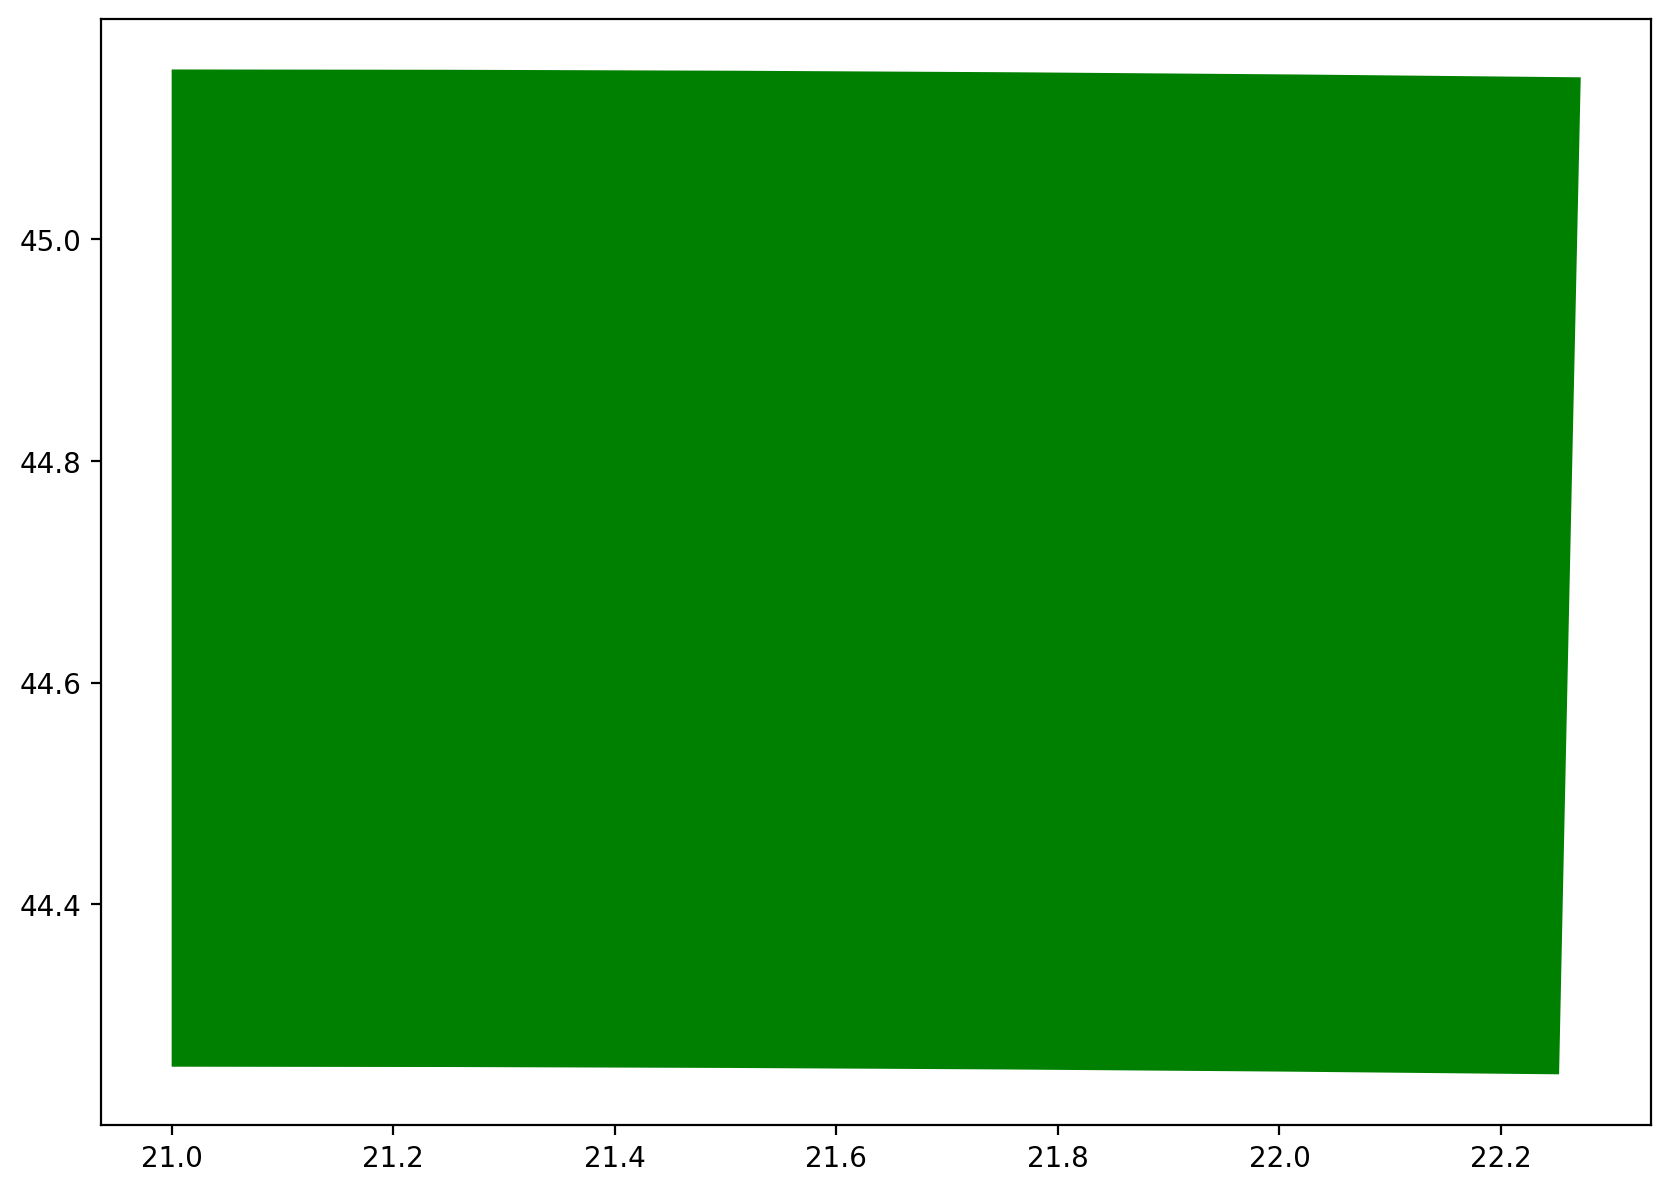

In [22]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns!
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

# now start the jobs
try:
    manager.run_jobs(start_job=point_extraction, job_db=job_db)
except Exception as e:
    tinfo = traceback.format_exc()
    print(str(e))
    print(tinfo)
    reset_tracker_file(job_tracker)

#### combine the single results into one training data file

First load all the single parquet files of the jobs into pandas.DataFrame and combine.

In [24]:
# load tracker file
df_tracker = pd.read_csv(job_tracker)

In [25]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
lMissing = []
if all_finished:
    print("All jobs are finished.")
else:
    lMissing.extend(df_tracker[df_tracker['status'] != 'finished'].job_name.tolist())
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

All jobs are finished.


In [26]:
# print the costs of the full job
print(f'The feature extraction for {df_tracker.n_points.sum()} reference points has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

The feature extraction for 1 reference points has cost overall 10 credits (0.1 EURO). 


In [27]:
# get the list of links to the job parquet files
df_tracker['path_result'] = df_tracker['file_prefix'].apply(lambda x: os.path.normpath(os.path.join(out_root, f'{x}.parquet')))
path_Results = df_tracker[df_tracker['status'] == 'finished']['path_result'].tolist()

In [28]:
# read parquet files and combine
result_df = pd.concat([pd.read_parquet(p) for p in path_Results], ignore_index=True)

In [29]:
# get a list of extracted feature names
feature_names = [x for x in result_df.columns.tolist() if x not in geo_df.columns.tolist()]
# remove some openEO generated columns
feature_names = [x for x in feature_names if x not in ["date", "feature_index", "geometry", "MGRSid10"]]

In [30]:
# put MGRSid10 from missing tiles in an own dataframe
df_missing = geo_df[geo_df.final_grouping.isin(lMissing)].copy()

In [31]:
# merge in results
result_df.set_index('MGRSid10', inplace=True)
result_df = geo_df[~geo_df.final_grouping.isin(lMissing)].join(result_df[feature_names], how='left').reset_index()

In [32]:
# check if all original reference points are handled
result_df.shape[0] + df_missing.shape[0] == geo_df.shape[0]

True

In [33]:
# save to disk as GeoPackage
file_name = os.path.basename(job_tracker).replace('.csv', '.gpkg')
path_gpkg = os.path.normpath(os.path.join(out_root, file_name))
result_df.to_file(path_gpkg, driver='GPKG')
# now save the missing reference points
file_name = os.path.basename(job_tracker).replace('.csv', '_missing.gpkg')
path_gpkg = os.path.normpath(os.path.join(out_root, file_name))
df_missing.to_file(path_gpkg, driver='GPKG')